# Thermistor Calibration Notebook

In [12]:
%matplotlib notebook 
from itertools import product, cycle

import matplotlib
from matplotlib import pyplot as plt
import pandas as pd

from numpy import ones, hstack, log, expand_dims, mean
from scipy.constants import convert_temperature
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table
from patsy import dmatrices

## Set of 12 thermistors were tested in a methanol bath
### Load thermistor calibration data from bath experiment

In [37]:
cal_data = pd.read_excel('thwaites_thermistor_calibration.xlsx')
cal_data = pd.melt(cal_data, value_name='resistance', var_name='length',
               id_vars=['group', 'seconds', 'temperature'], 
               value_vars=[6, 10, 20, 40])
cal_data['thermistor_id'] = cal_data.apply(
    lambda row: '{}_{}'.format(int(row.group), int(row.length)),
    axis=1)
cal_data.length = cal_data.length.astype(float)

### Plot of raw data

<IPython.core.display.Javascript object>


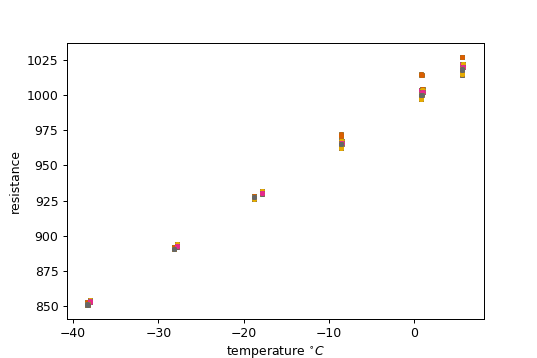

In [38]:
matplotlib.rcParams['figure.figsize'] = [6, 4]

markers = ['.']
cmap = plt.cm.Dark2.colors
scatter_styles = cycle(product(cmap, markers))

fig, ax1 = plt.subplots()

for (group, length), (color, marker) in zip(cal_data[['group', 'length']].values, scatter_styles):
    subset = cal_data[(cal_data.group == group) & (cal_data.length == length)]
    ax1.scatter(subset.temperature, subset.resistance, marker=marker, c=color)
    
ax1.set_xlabel('temperature $^{\circ}C$');
ax1.set_ylabel('resistance');

### Remove errant data

For the 3 high temperatures, one thermistor was observed to have not been fully
immersed for the experiment (group 3, length 20). Knowing this we can remove
these measurements.

In [39]:
cal_data = cal_data[~((cal_data.thermistor_id == '3_20') & (cal_data.temperature > -10))]

<IPython.core.display.Javascript object>


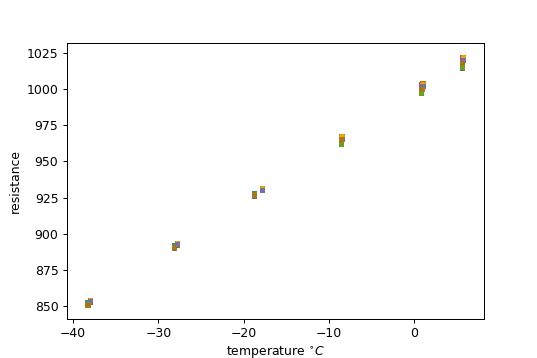

In [40]:
matplotlib.rcParams['figure.figsize'] = [6, 4]

markers = ['.']
cmap = plt.cm.Dark2.colors
scatter_styles = cycle(product(cmap, markers))

fig, ax1 = plt.subplots()

for (group, length), (color, marker) in zip(cal_data[['group', 'length']].values, scatter_styles):
    subset = cal_data[(cal_data.group == group) & (cal_data.length == length)]
    ax1.scatter(subset.temperature, subset.resistance, marker=marker, c=color)
    
ax1.set_xlabel('temperature $^{\circ}C$');
ax1.set_ylabel('resistance');

Looks more consistent with some greater variance at the higher temps but appears mostly linear.

### Temperature vs. resistance, length, and seconds

In [41]:
regr = sm.OLS.from_formula('temperature ~ resistance + length + seconds', data=cal_data)
fit = regr.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            temperature   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 9.991e+04
Date:                Sun, 07 Apr 2019   Prob (F-statistic):          2.23e-321
Time:                        14:57:36   Log-Likelihood:                -105.42
No. Observations:                 207   AIC:                             218.8
Df Residuals:                     203   BIC:                             232.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -262.4765      0.456   -575.649      0.000    -263.376    -261.577
resistance     0.2627      0.000    547.487      0.000       0.262       0.264
length         0.0123      0.002      5.836      0.000       0.008       0.016
seconds     4.586e-05      0.001      0.040      0.968      -0.002       0.002
==============================================================================
Omnibus:                       30.996   Durbin-Watson:                   0.232
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.792
Skew:                           1.026   Prob(JB):                     2.29e-09
Kurtosis:                       3.632   Cond. No.                     1.52e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.52e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Note: Time since immersion is not significant, but length is. The effect of
length is a positive coefficient that could amount to a difference of ~.5
degrees Celsius over 40m.

### Temperature vs. resistance, thermister_id

In [51]:
regr = sm.OLS.from_formula('temperature ~ resistance + thermistor_id', data=cal_data)
fit = regr.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            temperature   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.799e+04
Date:                Sun, 07 Apr 2019   Prob (F-statistic):               0.00
Time:                        15:01:53   Log-Likelihood:                -13.601
No. Observations:                 207   AIC:                             53.20
Df Residuals:                     194   BIC:                             96.53
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              -262.1586      0.309   -849.000      0.000    -262.768    -261.550
thermistor_id[T.1_20]    -0.4737      0.089     -5.324      0.000      -0.649      -0.298
thermistor_id[T.1_40]    -0.0924      0.089     -1.038      0.300      -0.268       0.083
thermistor_id[T.1_6]     -0.5106      0.089     -5.739      0.000      -0.686      -0.335
thermistor_id[T.2_10]     0.2553      0.089      2.869      0.005       0.080       0.431
thermistor_id[T.2_20]     0.5252      0.089      5.903      0.000       0.350       0.701
thermistor_id[T.2_40]     0.5080      0.089      5.709      0.000       0.333       0.684
thermistor_id[T.2_6]     -0.3940      0.089     -4.428      0.000      -0.569      -0.218
thermistor_id[T.3_10]    -0.3717      0.089     -4.177      0.000      -0.547      -0.196
thermistor_id[T.3_20]    -0.2772      0.110     -2.514      0.013      -0.495      -0.060
thermistor_id[T.3_40]     0.1044      0.089      1.173      0.242      -0.071       0.280
thermistor_id[T.3_6]     -0.1442      0.089     -1.620      0.107      -0.320       0.031
resistance                0.2627      0.000    819.967      0.000       0.262       0.263
==============================================================================
Omnibus:                        4.685   Durbin-Watson:                   0.319
Prob(Omnibus):                  0.096   Jarque-Bera (JB):                4.680
Skew:                           0.367   Prob(JB):                       0.0963
Kurtosis:                       2.934   Cond. No.                     1.61e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.61e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Note: there are significant differences between thermistors on the order of ~1
degree C.

### Temperature vs. resistance: Steinhart-Hart equation fit 

An empirical equation describing resistance vs temperature of semiconductor, and widely used to characterize thermistors is: 

$$ \frac{1}{T} = A + B \ln R + C \ln
R^3 $$
https://en.wikipedia.org/wiki/Steinhart%E2%80%93Hart_equation

In [43]:
y = 1/convert_temperature(cal_data.temperature, old_scale='Celsius', new_scale='Kelvin')
ln_r = log(expand_dims(cal_data.resistance, axis=1))
X = sm.add_constant(hstack((ln_r, ln_r**3)))

regr = sm.OLS(y, X)
fit = regr.fit()
fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.621e+05
Date:                Sun, 07 Apr 2019   Prob (F-statistic):               0.00
Time:                        14:57:52   Log-Likelihood:                 2198.3
No. Observations:                 207   AIC:                            -4391.
Df Residuals:                     204   BIC:                            -4381.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0727      0.004     18.059      0.000       0.065       0.081
x1            -0.0132      0.001    -14.972      0.000      -0.015      -0.011
x2          6.762e-05    6.3e-06     10.740      0.000    5.52e-05       8e-05
==============================================================================
Omnibus:                       18.993   Durbin-Watson:                   0.188
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.638
Skew:                          -0.782   Prob(JB):                     2.00e-05
Kurtosis:                       3.247   Cond. No.                     3.20e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.2e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Steinhart-Hart fit is essentially the same (a .02% better r2)

#### Fit by thermistor id should capture variation in the thermistors (including length).

In [24]:
cal_data = cal_data.sort_values(by=['resistance'])
y, X = dmatrices('temperature ~ resistance + thermistor_id', data=cal_data, return_type='dataframe')

regr = sm.OLS(y, X)
best_fit = regr.fit()
best_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            temperature   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.799e+04
Date:                Sun, 07 Apr 2019   Prob (F-statistic):               0.00
Time:                        14:53:14   Log-Likelihood:                -13.601
No. Observations:                 207   AIC:                             53.20
Df Residuals:                     194   BIC:                             96.53
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              -262.1586      0.309   -849.000      0.000    -262.768    -261.550
thermistor_id[T.1_20]    -0.4737      0.089     -5.324      0.000      -0.649      -0.298
thermistor_id[T.1_40]    -0.0924      0.089     -1.038      0.300      -0.268       0.083
thermistor_id[T.1_6]     -0.5106      0.089     -5.739      0.000      -0.686      -0.335
thermistor_id[T.2_10]     0.2553      0.089      2.869      0.005       0.080       0.431
thermistor_id[T.2_20]     0.5252      0.089      5.903      0.000       0.350       0.701
thermistor_id[T.2_40]     0.5080      0.089      5.709      0.000       0.333       0.684
thermistor_id[T.2_6]     -0.3940      0.089     -4.428      0.000      -0.569      -0.218
thermistor_id[T.3_10]    -0.3717      0.089     -4.177      0.000      -0.547      -0.196
thermistor_id[T.3_20]    -0.2772      0.110     -2.514      0.013      -0.495      -0.060
thermistor_id[T.3_40]     0.1044      0.089      1.173      0.242      -0.071       0.280
thermistor_id[T.3_6]     -0.1442      0.089     -1.620      0.107      -0.320       0.031
resistance                0.2627      0.000    819.967      0.000       0.262       0.263
==============================================================================
Omnibus:                        4.685   Durbin-Watson:                   0.496
Prob(Omnibus):                  0.096   Jarque-Bera (JB):                4.680
Skew:                           0.367   Prob(JB):                       0.0963
Kurtosis:                       2.934   Cond. No.                     1.61e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.61e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [25]:
pred = best_fit.get_prediction(X)
pred_summary = pred.summary_frame(alpha=.05)
pred_summary

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
199,-38.513164,0.069362,-38.649965,-38.376363,-39.057088,-37.969240
36,-38.759053,0.069489,-38.896104,-38.622002,-39.303040,-38.215066
37,-38.748546,0.069484,-38.885587,-38.611506,-39.292530,-38.204562
38,-38.732786,0.069475,-38.869810,-38.595762,-39.276766,-38.188806
198,-38.484270,0.069347,-38.621042,-38.347498,-39.028186,-37.940354
200,-38.465883,0.069338,-38.602636,-38.329130,-39.009795,-37.921971
127,-38.018734,0.069108,-38.155034,-37.882435,-38.562533,-37.474936
128,-38.018734,0.069108,-38.155034,-37.882435,-38.562533,-37.474936
126,-38.016108,0.069107,-38.152405,-37.879811,-38.559905,-37.472310
180,-37.951899,0.069074,-38.088133,-37.815666,-38.495681,-37.408118


In [54]:
cal_data = cal_data.sort_values(by=['resistance'])

final_regr = sm.OLS.from_formula('temperature ~ resistance + length', data=cal_data)
final_fit = final_regr.fit()
final_fit.save("therm_cal_model_a.pickle") 
final_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            temperature   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.506e+05
Date:                Sun, 07 Apr 2019   Prob (F-statistic):          4.94e-324
Time:                        15:04:04   Log-Likelihood:                -105.42
No. Observations:                 207   AIC:                             216.8
Df Residuals:                     204   BIC:                             226.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -262.4751      0.454   -578.729      0.000    -263.369    -261.581
resistance     0.2627      0.000    548.832      0.000       0.262       0.264
length         0.0123      0.002      5.851      0.000       0.008       0.016
==============================================================================
Omnibus:                       30.997   Durbin-Watson:                   0.365
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.793
Skew:                           1.026   Prob(JB):                     2.29e-09
Kurtosis:                       3.632   Cond. No.                     1.52e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.52e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<IPython.core.display.Javascript object>


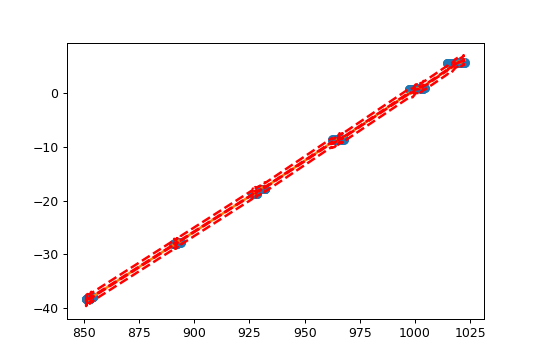

In [56]:
pred = final_fit.get_prediction()
pred_summary = pred.summary_frame(alpha=.05)
x = cal_data.resistance
y = cal_data.temperature

fig, ax = plt.subplots()
ax.plot(x, y, 'o')
ax.plot(x, pred_summary['mean'], '-', lw=2)
ax.plot(x, pred_summary.mean_ci_lower, 'r--', lw=2)
ax.plot(x, pred_summary.mean_ci_upper, 'r--', lw=2)
ax.plot(x, pred_summary.obs_ci_lower, 'r--', lw=2)
ax.plot(x, pred_summary.obs_ci_upper, 'r--', lw=2)

In [90]:
pred_summary

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
199,-38.513164,0.069362,-38.649965,-38.376363,-39.057088,-37.969240
36,-38.759053,0.069489,-38.896104,-38.622002,-39.303040,-38.215066
37,-38.748546,0.069484,-38.885587,-38.611506,-39.292530,-38.204562
38,-38.732786,0.069475,-38.869810,-38.595762,-39.276766,-38.188806
198,-38.484270,0.069347,-38.621042,-38.347498,-39.028186,-37.940354
200,-38.465883,0.069338,-38.602636,-38.329130,-39.009795,-37.921971
127,-38.018734,0.069108,-38.155034,-37.882435,-38.562533,-37.474936
128,-38.018734,0.069108,-38.155034,-37.882435,-38.562533,-37.474936
126,-38.016108,0.069107,-38.152405,-37.879811,-38.559905,-37.472310
180,-37.951899,0.069074,-38.088133,-37.815666,-38.495681,-37.408118
